In [1]:
import os
import random
import pickle
import torch
import torchvision
import pandas as pd
import numpy as np
from torch import nn

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

/home/obi-1-konobe/projects/dp/music_similarity/venv/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


device(type='cpu')

In [3]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)
torch.cuda.manual_seed(123)
torch.backends.cudnn.deterministic = True

In [4]:
import torchvision.transforms as transforms
from torch import nn

In [90]:
class EncModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
            torch.nn.Conv2d(1, 64, 3, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU()
        )
        self.pool0 =  torch.nn.MaxPool2d((2, 4)) # 64x312

        self.enc_conv1 = nn.Sequential(
            torch.nn.Conv2d(64, 128, 3, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU()
        )
        self.pool1 =  torch.nn.MaxPool2d((2, 4)) # 32x78

        self.enc_conv2 = nn.Sequential(
            torch.nn.Conv2d(128, 256, 3, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU()
        )
        self.pool2 =  torch.nn.MaxPool2d((2, 4)) # 16x19

        self.enc_conv3 = nn.Sequential(
            torch.nn.Conv2d(256, 512, 3, padding=1),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU()
            
        )
        self.pool3 =  torch.nn.MaxPool2d((2, 4)) # 8x4

#         self.bottle_neck = torch.nn.Conv2d(512, 1024, (8,4))

    
    def forward(self, x):
        e0 = self.pool0(self.enc_conv0(x))
        e1 = self.pool1(self.enc_conv1(e0))
        e2 = self.pool2(self.enc_conv2(e1))
        e3 = self.pool3(self.enc_conv3(e2))
#         e4 = self.bottle_neck(e3)
        return e3

In [91]:
class DecModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.upsample_bn = nn.UpsamplingBilinear2d(size=(8,4))
        self.dec_conv_bn = nn.Sequential(
          nn.Conv2d(1024, 512, 3, padding=1),
          nn.BatchNorm2d(512),
          nn.ReLU()
        )

        self.upsample0 = nn.UpsamplingBilinear2d(size=(16,19))
        self.dec_conv0 = nn.Sequential(
          nn.Conv2d(512, 256, 3, padding=1),
          nn.BatchNorm2d(256),
          nn.ReLU()
        )

        self.upsample1 = nn.UpsamplingBilinear2d(size=(32,78))
        self.dec_conv1 = nn.Sequential(
          nn.Conv2d(256, 128, 3, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU()
        )

        self.upsample2 = nn.UpsamplingBilinear2d(size=(64,312))
        self.dec_conv2 = nn.Sequential(
          nn.Conv2d(128, 64, 3, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU()
        )

        self.upsample3 = nn.UpsamplingBilinear2d(size=(128,1248))
        self.dec_conv3 = nn.Sequential(
          nn.Conv2d(64, 1, 3, padding=1),
          nn.BatchNorm2d(1),
          nn.ReLU(),
          nn.Conv2d(1, 1, 1)
        )

    
    def forward(self, x):
        bn = self.dec_conv_bn(self.upsample_bn(x))
        d0 = self.dec_conv0(self.upsample0(bn))
        d1 = self.dec_conv1(self.upsample1(d0))
        d2 = self.dec_conv2(self.upsample2(d1))
        d3 = self.dec_conv3(self.upsample3(d2))

        return d3


In [48]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.pool0 = nn.MaxPool2d((2, 4))  # 64x312
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d((2, 4)) # 32x78
        
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d((2, 4)) # 16x19
        
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d((2, 4)) # 8x4

        # bottleneck
        self.bottle_neck = torch.nn.Conv2d(256, 1024, (8,4))
        
        self.upsample_bn = nn.UpsamplingBilinear2d(size=(8,4))
        self.dec_conv_bn = nn.Sequential(
          nn.Conv2d(1024, 256, 3, padding=1),
          nn.BatchNorm2d(256),
          nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample0 = nn.UpsamplingBilinear2d(size=(16,19)) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        self.upsample1 = nn.UpsamplingBilinear2d(size=(32,78)) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.upsample2 = nn.UpsamplingBilinear2d(size=(64,312))  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.upsample3 = nn.UpsamplingBilinear2d(size=(128,1248))  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 1, 3, padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU(),
            nn.Conv2d(1, 1, 1)
        )

    def forward(self, x):
        # encoder
        e0 = self.pool0(self.enc_conv0(x))
        e1 = self.pool1(self.enc_conv1(e0))
        e2 = self.pool2(self.enc_conv2(e1))
        e3 = self.pool3(self.enc_conv3(e2))

#         bottleneck
        b = self.bottle_neck(e3)
        bn = self.dec_conv_bn(self.upsample_bn(b))
        # decoder
        d0 = self.dec_conv0(self.upsample0(torch.cat([e3, bn], dim=1)))
        d1 = self.dec_conv1(self.upsample1(torch.cat([e2, d0], dim=1)))
        d2 = self.dec_conv2(self.upsample2(torch.cat([e1, d1], dim=1)))
        d3 = self.dec_conv3(self.upsample3(torch.cat([e0, d2], dim=1)))  # no activation
        
        return d3

In [49]:
unet = torch.load('../data/pickles/models/unet_03.01.125.pth')

In [18]:
model = nn.Sequential(
    unet.enc_conv0,
    unet.pool0,
    unet.enc_conv1,
    unet.pool1,
    unet.enc_conv2,
    unet.pool2,
    unet.enc_conv3,
    unet.pool3,
    unet.bottle_neck
)

In [92]:
encoder = torch.load('../data/pickles/models/enc_03.01.1101.pth')
decoder = torch.load('../data/pickles/models/dec_03.01.1101.pth')

RuntimeError: CUDA error: unspecified launch failure

In [55]:
img = test_dataset[0][0]
img = img.permute(1,2,0).numpy()
img.shape

(128, 1248, 1)

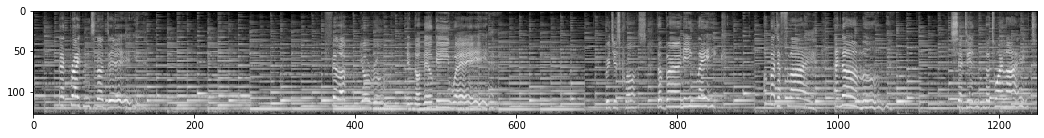

In [85]:
from skimage.io import imshow
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(18, 2))
ax.imshow(img, interpolation='nearest', cmap='gray')

In [78]:
unet_img = test_dataset[0][0].unsqueeze(0).to(device)
unet_img = unet(unet_img)


In [79]:
unet_img = torch.squeeze(unet_img, 0).cpu()
unet_img.shape

torch.Size([1, 128, 1248])

In [80]:
unet_img = unet_img.permute(1,2,0).detach().numpy()

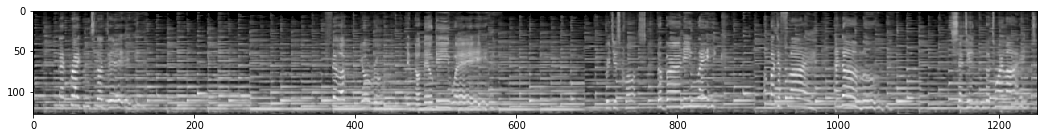

In [86]:
# unet_img = unet_img.permute(1,2,0).d.numpy()
fig, ax = plt.subplots(figsize=(18, 2))
ax.imshow(unet_img, interpolation='nearest', cmap='gray')

In [19]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [20]:
# Normalize training set together with augmentation
one_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
#     transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.0069], [0.0033])
])

train_dir = '../data/spectrograms/train/train/'
val_dir = '../data/spectrograms/train/val/'
test_dir = '../data/spectrograms/test/'

batch_size = 16
test_dataset = ImageFolderWithPaths(test_dir, one_transform)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=8
)

train_dataset = ImageFolderWithPaths(train_dir, one_transform)
val_dataset = ImageFolderWithPaths(val_dir, one_transform)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=8
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=8
)

# class_names = train_dataset.classes


# Loading Tiny ImageNet dataset
# trplt_path = '../pickles_for_git/triplets.p'
# batch_szie = 32
# trainset = TripletDataset(triplet_path=trplt_path, transform=one_transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_szie, num_workers=8)

# testset = TripletImageLoader(
#     base_path=root, triplets_filename="", transform=transform_test, train=False)
# testloader = torch.utils.data.DataLoader(
#     testset, batch_size=batch_size_test, num_workers=32)

In [21]:
len(test_dataloader), len(test_dataset)

(7, 97)

In [22]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs, x, path in test_loader:
            inputs = inputs.to(device)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = torch.nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [45]:
model = model.to(device)
unet = unet.to(device)

In [43]:
with torch.no_grad():
    logits = []

    for inputs, x, path in test_dataloader:
        inputs = inputs.to(device)
        model.eval()
        outputs = model(inputs).cpu()
        outputs = outputs.view(outputs.shape[0], -1)
        logits.append(outputs)
        break

In [44]:
logits[0][0]

tensor([156.6461,  83.5573, -94.5983,  ..., 246.0500,  -3.9503, 174.1174])

In [46]:
with torch.no_grad():
    logits = []

    for inputs, x, path in test_dataloader:
        inputs = inputs.to(device)
        unet.eval()
        outputs = unet(inputs).cpu()
        outputs = outputs.view(outputs.shape[0], -1)
        logits.append(outputs)
        break

In [47]:
logits[0][0]

tensor([156.6461,  83.5573, -94.5983,  ..., 246.0500,  -3.9503, 174.1174])

In [28]:
with torch.no_grad():
    logits = []
    path_list = list()
    for inputs, x, path in test_dataloader:
        inputs = inputs.to(device)
        model.eval()
        outputs = model(inputs).cpu()
        outputs = outputs.view(outputs.shape[0], -1)
        logits.append(outputs)
        path_list.append(path)

In [29]:
with torch.no_grad():
#     logits = []
#     path_list = list()
    for inputs, x, path in val_dataloader:
        inputs = inputs.to(device)
        model.eval()
        outputs = model(inputs).cpu()
        outputs = outputs.view(outputs.shape[0], -1)
        logits.append(outputs)
        path_list.append(path)

In [30]:
with torch.no_grad():
#     logits = []
#     path_list = list()
    for inputs, x, path in train_dataloader:
        inputs = inputs.to(device)
        model.eval()
        outputs = model(inputs).cpu()
        outputs = outputs.view(outputs.shape[0], -1)
        logits.append(outputs)
        path_list.append(path)

In [31]:
path_list[0][0]

'../data/spectrograms/test/unknown/000190.png'

In [32]:
logits[0][0].shape[0]

1024

In [33]:
emb_list = list()
for i in logits:
    for tens in i:
        emb_list.append(tens.numpy())

In [34]:
embeddings = pd.DataFrame(emb_list)

In [35]:
track_list = list()
for i in path_list:
    for path in i:
        name = path.split('/')[-1]
        ids = name.split('.')[0]
        track_list.append(ids)

In [36]:
embeddings['id'] = track_list

In [37]:
embeddings = embeddings[['id'] + list(np.arange(logits[0][0].shape[0]))]

In [38]:
embeddings

,id,0,1,2,3,4,5,6,7,8,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,000190,156.646072,83.557297,-94.598328,98.127167,23.319267,-98.801773,-32.635357,128.132431,-293.424622,...,-254.128464,216.904770,34.264751,259.369537,262.224152,-45.288532,3.258972,246.049988,-3.950350,174.117371
1,000194,159.938828,89.845703,-95.822128,96.456535,20.501625,-101.933586,-32.576878,126.654526,-294.283539,...,-253.759888,219.407288,32.804764,260.056061,261.140167,-46.998150,5.446586,245.619446,-0.911344,173.086258
2,000667,147.850281,76.242889,-100.819969,165.779968,20.303211,-114.900276,-60.726059,166.223648,-304.775879,...,-265.932861,229.990280,56.619762,255.591339,277.658386,-66.317642,-31.380980,260.343964,10.492521,180.362778
3,001040,141.113174,72.381210,-91.666672,136.851166,17.151062,-106.115318,-46.331360,150.686707,-284.677124,...,-254.017151,216.506592,51.864471,246.983093,259.163177,-58.730022,-23.227377,254.679657,7.696369,169.046371
4,001686,146.132935,81.533203,-91.399498,94.681839,24.558151,-91.427864,-42.148628,131.035995,-282.563049,...,-240.850189,209.426315,39.551353,245.066757,257.999237,-42.976643,2.894571,236.419159,-4.404028,172.741028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7989,149416,149.739944,77.475075,-98.249809,155.600830,16.004913,-115.587349,-51.566837,158.908142,-297.128601,...,-262.531342,226.924606,52.789318,253.871780,267.453827,-65.484749,-30.751825,259.004364,13.151434,173.369232
7990,149417,147.106461,81.695602,-93.131027,116.538239,17.476315,-103.181488,-43.092674,138.586823,-287.081512,...,-251.005035,217.487076,44.321316,246.953705,258.180511,-52.234150,-10.839879,245.006058,6.757160,169.701370
7991,149452,141.928879,76.751923,-89.896866,117.963989,20.193237,-97.116798,-48.774654,148.751724,-282.294678,...,-245.248276,212.512283,51.176250,239.180481,258.635529,-53.880775,-14.379851,244.512024,3.812969,171.112411
7992,149488,147.161316,72.594284,-100.450783,165.474731,19.228283,-116.729347,-55.420387,164.595322,-301.022583,...,-264.807465,227.565613,55.463787,258.831818,272.107147,-68.121178,-33.686432,262.871735,11.363172,176.006119


In [39]:
embeddings.to_csv('../data/csv/unet_embeddings.csv', index=False)